In [1]:
import glob
import pickle
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family']='Helvetica'
plt.rcParams['font.size']=14

In [2]:
from keras.models import Model, Sequential
from keras.layers import Conv1D,LSTM,Bidirectional,GRU,Input,Dropout,BatchNormalization,Reshape,Activation
from keras.layers import UpSampling1D,UpSampling2D, Conv2D,TimeDistributed,Dense
from keras.optimizers import Adam


Using TensorFlow backend.
/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda2/envs/seismo/lib/python3.7/sit

In [38]:
def generate_gaussian(mean,std=10,length=30000):
    x_values = np.arange(0,length)
    y_values = scipy.stats.norm(mean,std)
    y_values = y_values.pdf(x_values)
    #re-escale to peak at one
    y_values = y_values/np.max(y_values)
    # truncate at 2 sigmas
    y_truncated = np.zeros((30000))
    y_truncated[int(mean-2*std):int(mean+2*std)] = y_values[int(mean-2*std):int(mean+2*std)]
    
    return y_values,y_truncated

def generate_box(index1,index2,length=30000):
    y_label = np.zeros((length))
    end = int((index2-index1)*1.4)
    y_label[int(index1):int(index2)+end] = 1
    return y_label

def generate_box_short(index1,index2,length=996):
    y_label = np.zeros((length))
    index1 = int(index1/30)
    index2 = int(index2/30)
    end = int((index2-index1)*1.4)
    y_label[int(index1):int(index2)+end] = 1
    return y_label

def plot_spectrogram(seismogram):
    # pass one channel at a time and fix the window values
    fs   = 100
    nfft = 128
    noverlap = 98
    spectrum,freqs,bins,im = plt.specgram(seismogram,nfft,fs,noverlap=noverlap,cmap='jet')
    return spectrum

def create_spec_one(data):
    x = plot_spectrogram(data['data'][-1])
    x = np.expand_dims(x,axis=0)
    return x

def create_spec_three(data):
    X = []
    for i in range(len(data['data'])):
        x = plot_spectrogram(data['data'][i])
        x = np.expand_dims(x,axis=0)
        X.append(x)
        # concatenate the matrices
    X = np.concatenate(X,axis=0)
    return X

def create_spec_three_stack(data):
    X = []
    for i in range(len(data['data'])):
        x = plot_spectrogram(data['data'][i])
        #x = np.expand_dims(x,axis=0)
        X.append(x)
        # concatenate the matrices
    X = np.concatenate(X,axis=0)
    return X



def create_training_example(filename):
    # load the pickle file
    a_file = open(filename,'rb')
    data  = pickle.load(a_file)
    x     = data['data']
    y = np.zeros((5,30000))
    # check if the initial phase is Pg or Pn
    if data['Pn']!=0:
        box  = generate_box(data['Pn'],data['Sn'])
        _, y_pn = generate_gaussian(mean=data['Pn'])
        
    if data['Pg']!=0:
        box  = generate_box(data['Pg'],data['Sg'])
        _, y_pg = generate_gaussian(mean=data['Pg'])
        
    if data['Pn']==0:
        y_pn = np.zeros(30000)   
    if data['Pg']==0:
        y_pg = np.zeros(30000)
        
        
    if data['Sn']==0:
        y_sn = np.zeros(30000)
    if data['Sn']!=0:
        _, y_sn = generate_gaussian(mean=data['Sn'])
    
    if data['Sg']==0:
        y_sg = np.zeros(30000)
    if data['Sg']!=0:
        _,y_sg = generate_gaussian(mean=data['Sg'])
    
    #y = (box,y_pg,y_pn,y_sg,y_sn)
    
    y[0,:] = box; y[1,:] = y_pg; y[2,:] = y_pn; y[3,:] = y_sg; y[4,:] = y_sn;
    
        
    return x,y


def create_training_example_spec(filename):
    # load the pickle file
    a_file = open(filename,'rb')
    data  = pickle.load(a_file)
    
    if data['Pn']!=0:
        box  = generate_box_short(data['Pn'],data['Sn'])
        
    if data['Pg']!=0:
        box  = generate_box_short(data['Pg'],data['Sg'])
        
    # generate the spectrogram using just one component
    x = create_spec_one(data)
    y = box
    
    return x,y

def create_training_example_spec_three(filename):
    a_file = open(filename,'rb')
    data  = pickle.load(a_file)
    if data['Pn']!=0:
        box  = generate_box_short(data['Pn'],data['Sn'])
        
    if data['Pg']!=0:
        box  = generate_box_short(data['Pg'],data['Sg'])
        
    x = create_spec_three_stack(data)
    y = box
    
    return x,y
    
def create_training_example_spec_three_stack(filename):
    a_file = open(filename,'rb')
    data  = pickle.load(a_file)
    if data['Pn']!=0:
        box  = generate_box_short(data['Pn'],data['Sn'])
        
    if data['Pg']!=0:
        box  = generate_box_short(data['Pg'],data['Sg'])
        
    x = create_spec_three_stack(data)
    y = box
    
    return x,y


def plot_example(x,y):
    plt.figure(figsize=(15,6)) 
    components = ['E','N','Z']
    for i in range(x.shape[0]):
        plt.subplot(3,1,i+1)
        
        plt.plot(x[i,:],c='k',linewidth=0.3,alpha=0.5)
        plt.plot(y[0,:],label='box')
        plt.plot(y[1,:],label='Pg');plt.plot(y[2,:],label='Pn');plt.plot(y[3,:],label='Sg');plt.plot(y[4,:],label='Sn')
        plt.text(1000,0.5,components[i],fontsize=18)
        
        plt.xlim(0,30000)
        plt.legend(loc='upper right',fontsize=13)
        
        
def load_multiple(m,folder='batch3'):
    """
    Loads m examples and concatentaes them into an input and output tensor
    """
    filenames = glob.glob(folder+'/data*pkl')
    randint = np.random.randint(int(len(filenames)-m))
    filenames = filenames[randint:int(randint+m)]
    # initialize tensors
    X = np.zeros((m,3,30000))
    Y = np.zeros((m,5,30000))
    #Y_spec = np.zeros((m,996))
    
    for i,filename in enumerate(filenames):
        x,y = create_training_example(filename)
        X[i,:,:]   = x
        Y[i,:,:]   = y
    return X,Y


def load_multiple_spec(m,folder='batch3'):
    """
    Loads m examples and concatenates them into an input and output tensor
    """
    
    filenames = glob.glob(folder+'/data*pkl')
    randint   = np.random.randint(int(len(filenames)-m))
    filenames = filenames[randint:int(randint+m)]
    
    # initialize tensors
    X = np.zeros((m,65,996))
    Y = np.zeros((m,996))
    
    for i,filename in enumerate(filenames):
        x,y = create_training_example_spec(filename)
        X[i,:,:]   = x
        Y[i,:]   = y
    return X,Y

def load_multiple_spec_three(m,folder='batch3'):
    filenames = glob.glob(folder+'/data*pkl')
    randint   = np.random.randint(int(len(filenames)-m))
    filenames = filenames[randint:int(randint+m)]  
    
    # initialize tensors
    X = np.zeros((m,195,996))
    Y = np.zeros((m,996))
    for i,filename in enumerate(filenames):
        x,y = create_training_example_spec_three(filename)
        X[i,:,:]   = x
        Y[i,:]   = y
    return X,Y


def plot_predictions(X_pred,Y_pred,preds):
    """
    plot a random prediction
    """
    randint = np.random.randint(int(Y_pred.shape[0]))
    
    # make ticks reflect the time scale, 300 seconds
    delta  = (996*60)/300
    xticks = np.arange(0,301,60)
    xvals  = np.arange(0,966,delta)
    
    plt.figure()
    plt.subplot(211)
    plt.plot(Y_pred[randint,:],c='b',linestyle='--',label='target',alpha=0.5)
    plt.plot(preds[randint,:],c='r',label='prediction')
    plt.xlim(0,997)
    plt.xticks(xvals,xticks)
    plt.legend()
    
    plt.subplot(212)
    plt.imshow(np.log(X_pred[randint,:,:].T),cmap='jet',aspect='auto',origin='lower')
    plt.xticks(xvals,xticks)
    plt.xlabel('seconds')
    
    
    
def plot_predictions_wav(X_pred,Y_pred,preds):
    randint = np.random.randint(int(Y_pred.shape[0]))
    
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(Y_pred[randint,:],c='b',linestyle='--',label='target',alpha=0.5)
    plt.plot(preds[randint,:],c='r',label='prediction')
    
    plt.subplot(2,1,2)
    for i in range(3):
        plt.plot(X_pred[randint,:,i]-i)
        
    

In [54]:
X_train_spec_three, Y_train_spec_three = load_multiple_spec_three(10)
print(X_train_spec_three.shape, Y_train_spec_three.shape )

(10, 3, 65, 996) (10, 996)


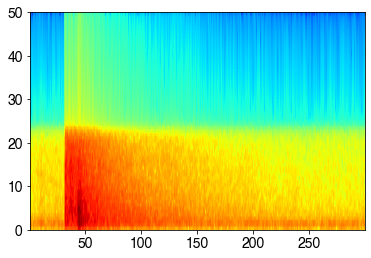

In [5]:
X_train_spec,Y_train_spec = load_multiple_spec(10)

In [ ]:
X_train_spec.shape

In [ ]:
x2,y2 = create_training_example_spec('data__Pn_3016.pkl')

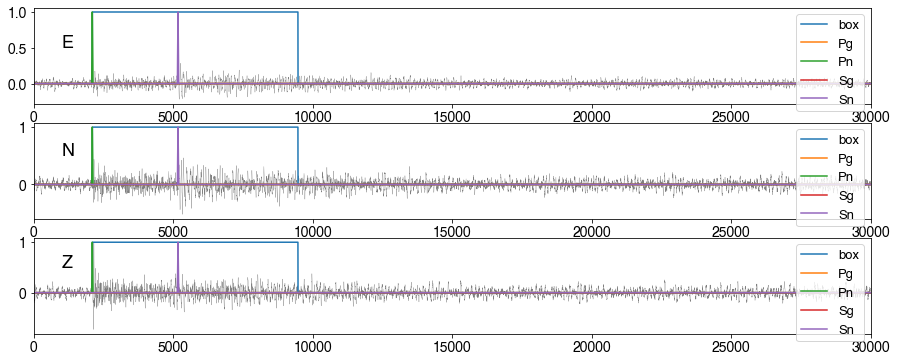

In [30]:
x1,y1 = create_training_example('batch3/data__Pn_3000.pkl')
plot_example(x1,y1)

In [ ]:
X_train,Y_train = load_multiple(300)

X_train = np.swapaxes(X_train,1,2)
Y_train = np.swapaxes(Y_train,1,2)
print(X_train.shape,Y_train.shape)

In [ ]:
Y_train = Y_train[:,2,:]  # this gives the Pn label 
# access the labels in this order:
# 0 -> box
# 1 -> pg
# 2 -> pn
# 3 -> sg
# 4 -> sn

# Using spectrograms

In [10]:

def model(input_shape):
    
    X_input = Input(shape=input_shape)
    
    # Convoultion layer
    X = Conv1D(filters=128,strides=1,kernel_size=16,padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.2)(X)
    
    # Bi - LSTM
    X = Bidirectional(LSTM(units=128,return_sequences=True))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.2)(X)
    
    # Bi - LSTM 
    X = Bidirectional(LSTM(units=128,return_sequences=True))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.2)(X)

    
    X = TimeDistributed(Dense(1,activation='sigmoid'))(X)
    
    
    model=Model(inputs=X_input,outputs=X)
    
    return model
    

In [5]:
model = model(input_shape=(996,65))

In [6]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 996, 65)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          133248    
_________________________________________________________________
batch_normalization_1 (Batch (None, 996, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 996, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 996, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 996, 256)          263168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 996, 256)          1024

In [8]:
optim = Adam(lr=0.00005,beta_1=0.9,beta_2=0.999,decay=0.00001)
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['binary_crossentropy'])

/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7581: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


(5000, 996, 65) (5000, 996, 1)


/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


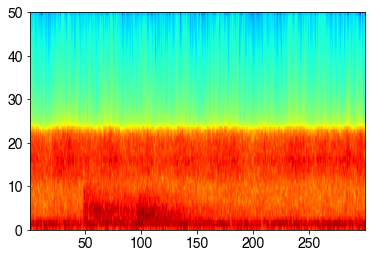

In [9]:
X_train_spec,Y_train_spec = load_multiple_spec(5000)
X_train_spec = np.swapaxes(X_train_spec,1,2)
Y_train_spec = np.expand_dims(Y_train_spec,axis=2)
print(X_train_spec.shape,Y_train_spec.shape)

In [10]:
# train
model.fit(X_train_spec,Y_train_spec,epochs=10,batch_size=32)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10
5000/5000 [==============================] - 404s 81ms/step - loss: 0.4188 - binary_crossentropy: 0.4188
Epoch 2/10
5000/5000 [==============================] - 406s 81ms/step - loss: 0.3478 - binary_crossentropy: 0.3478
Epoch 3/10
5000/5000 [==============================] - 409s 82ms/step - loss: 0.3339 - binary_crossentropy: 0.3339
Epoch 4/10
5000/5000 [==============================] - 411s 82ms/step - loss: 0.3241 - binary_crossentropy: 0.3241
Epoch 5/10
5000/5000 [==============================] - 410s 82ms/step - loss: 0.3165 - binary_crossentropy: 0.3165
Epoch 6/10
5000/5000 [==============================] - 405s 81ms/step - loss: 0.3087 - binary_crossentropy: 0.3087
Epoch 7/10
5000/5000 [==============================] - 405s 81ms/step - loss: 0.2996 - binary_crossentropy: 0.2996
Epoch 8/10
5000/5000 [==============================] - 404s 81ms/step - loss: 0.2905 - binar

In [11]:
model.save('spec_model1')

In [30]:
# plot predictions
X_pred_spec,Y_pred_spec = load_multiple_spec(100)
X_pred_spec = np.swapaxes(X_pred_spec,1,2)
#Y_pred_spec = np.swapaxes(Y_pred_spec,1,2)

/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7581: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


In [31]:
spec_preds = model.predict(X_pred_spec)

In [13]:
spec_preds.shape

(10, 996, 1)

In [57]:
X_pred_spec.shape

(10, 996, 65)

In [ ]:
plt.plot(spec_preds[8,:,:])

In [55]:
%matplotlib inline

<IPython.core.display.Javascript object>


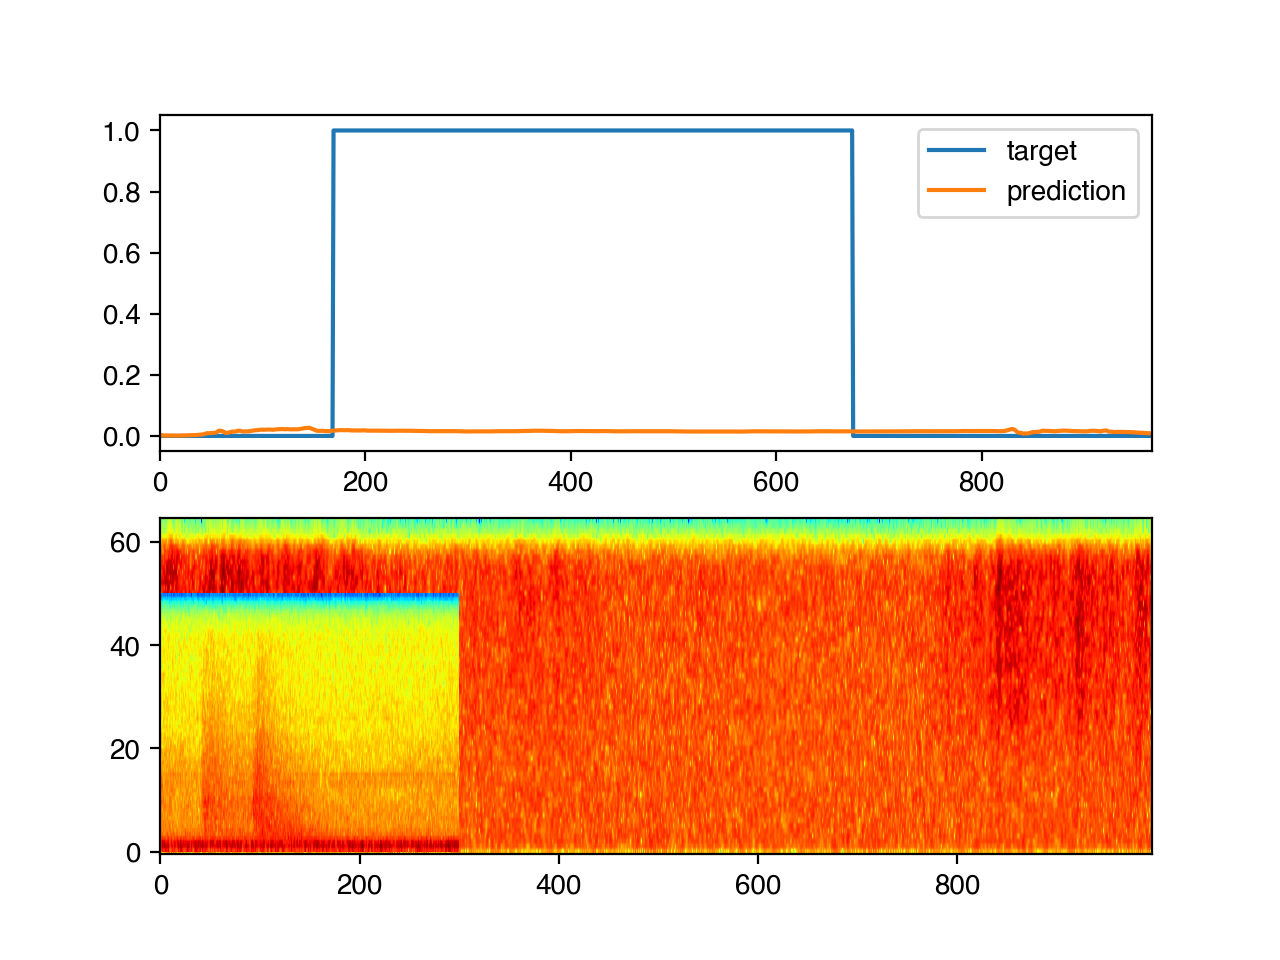

In [45]:
plot_predictions(X_pred_spec,Y_pred_spec,spec_preds)

# Using the three components, the vertical and the two horizontal ones.
## The input is created by concatenating the spectrograms of each component 
Here, we employ the same architecture as we did before, but compile the model to take a differently shaped input.
Previously, each training example was of shape (996,65), but now, by concatenating three of these along the second axis, we get an input of shape (996,195). As a consequence, a batch of $m$ examples is of shape (m,996,195)
The learning rate has been adjusted from the previous model



In [5]:
model_three = model(input_shape=(996,195))

In [6]:
model_three.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 996, 195)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          399488    
_________________________________________________________________
batch_normalization_1 (Batch (None, 996, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 996, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 996, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 996, 256)          263168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 996, 256)          1024

In [7]:
optim = Adam(lr=0.0005,beta_1=0.9,beta_2=0.999,decay=0.00001)
model_three.compile(loss='binary_crossentropy', optimizer=optim, metrics=['binary_crossentropy'])

/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7581: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


(10000, 996, 195) (10000, 996, 1)


/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


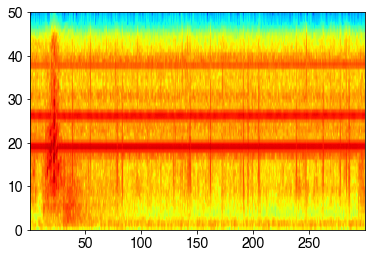

In [8]:
X_train_spec_three,Y_train_spec_three = load_multiple_spec_three(10000)
X_train_spec_three = np.swapaxes(X_train_spec_three,1,2)
Y_train_spec_three = np.expand_dims(Y_train_spec_three,axis=2)
print(X_train_spec_three.shape,Y_train_spec_three.shape)

In [9]:
model_three.fit(X_train_spec_three,Y_train_spec_three,epochs=10,batch_size=32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10
10000/10000 [==============================] - 943s 94ms/step - loss: 0.2264 - binary_crossentropy: 0.2264
Epoch 2/10
10000/10000 [==============================] - 934s 93ms/step - loss: 0.1720 - binary_crossentropy: 0.1720
Epoch 3/10
10000/10000 [==============================] - 922s 92ms/step - loss: 0.1359 - binary_crossentropy: 0.1359
Epoch 4/10
10000/10000 [==============================] - 948s 95ms/step - loss: 0.1152 - binary_crossentropy: 0.1152
Epoch 5/10
10000/10000 [==============================] - 934s 93ms/step - loss: 0.0984 - binary_crossentropy: 0.0984
Epoch 6/10
10000/10000 [==============================] - 928s 93ms/step - loss: 0.0922 - binary_crossentropy: 0.0922
Epoch 7/10
10000/10000 [==============================] - 921s 92ms/step - loss: 0.0814 - binary_crossentropy: 0.0814
Epoch 8/10
10000/10000 [==============================] - 923s 92ms/step - loss

In [10]:
model_three.save('model_spec_three_random')

In [11]:
train_preds = model_three.predict(X_train_spec_three)

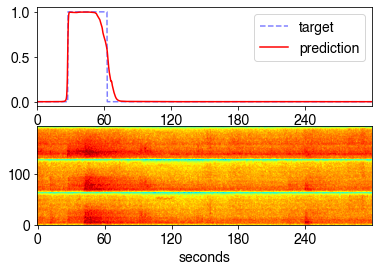

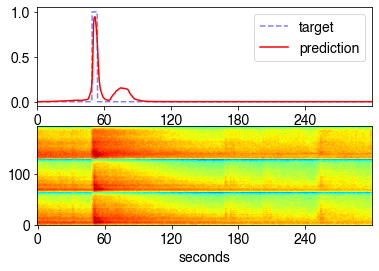

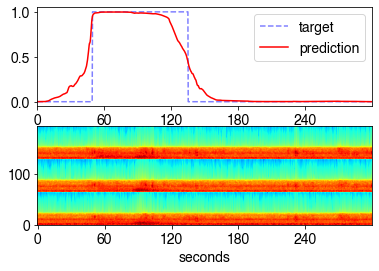

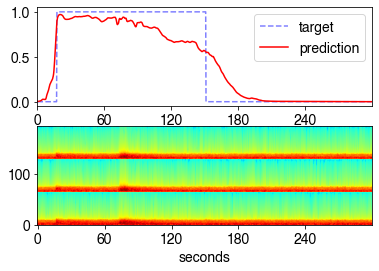

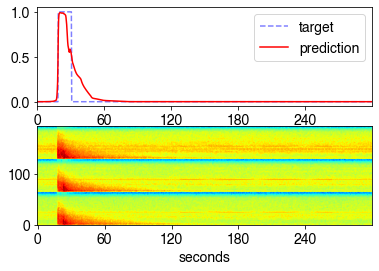

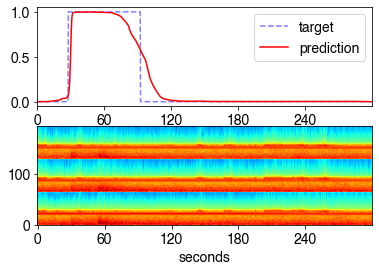

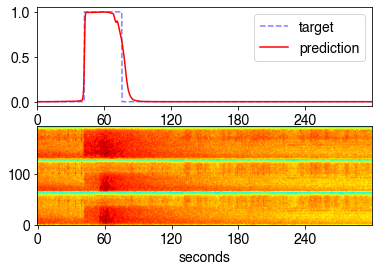

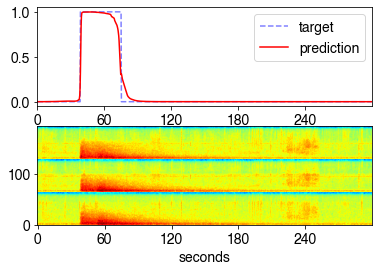

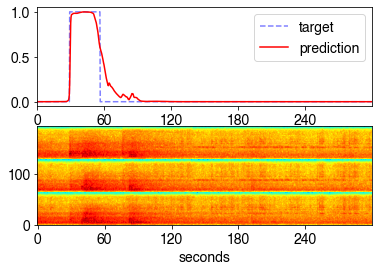

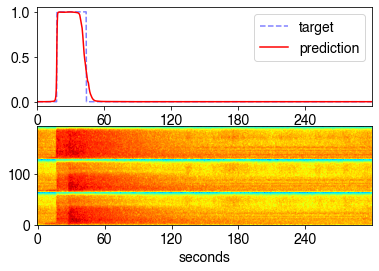

In [148]:
plt.close()
for i in range(10):
    plot_predictions(X_train_spec_three,Y_train_spec_three,train_preds)
    

In [54]:
history = model_three.history.history

Text(0, 0.5, 'Loss')

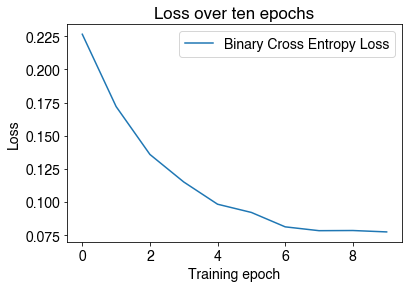

In [82]:
plt.plot(history['loss'],label='Binary Cross Entropy Loss')
plt.title('Loss over ten epochs')
plt.legend()
plt.xlabel('Training epoch')
plt.ylabel('Loss')


In [136]:
history.keys()


dict_keys(['loss', 'binary_crossentropy'])

In [149]:
# Predictions from unseen examples

(100, 996, 195) (100, 996, 1)


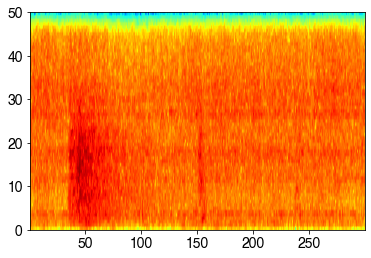

In [152]:
X_test_spec_three,Y_test_spec_three = load_multiple_spec_three(100,folder='batchtest')
X_test_spec_three = np.swapaxes(X_test_spec_three,1,2)
Y_test_spec_three = np.expand_dims(Y_test_spec_three,axis=2)
print(X_test_spec_three.shape,Y_test_spec_three.shape)

In [153]:
test_preds = model_three.predict(X_test_spec_three)

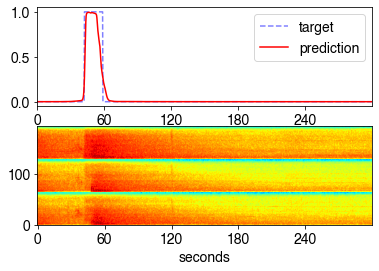

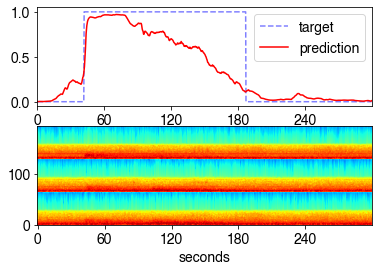

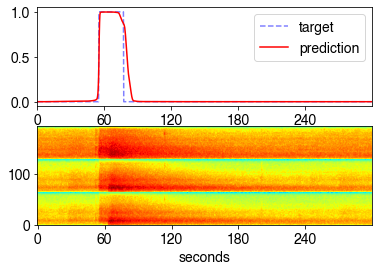

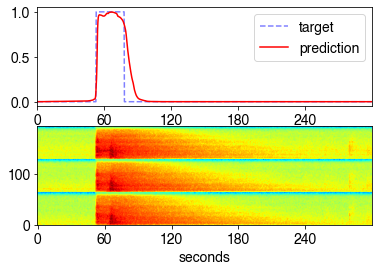

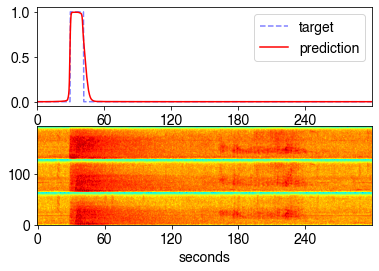

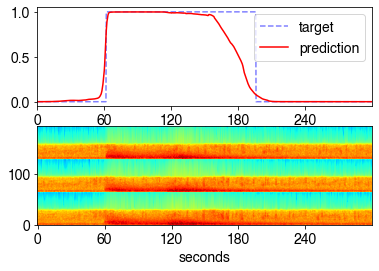

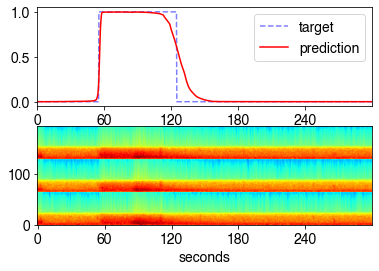

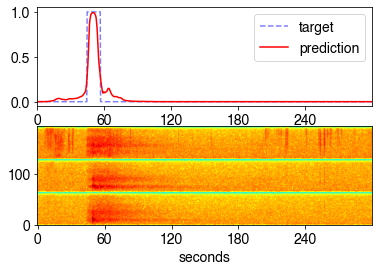

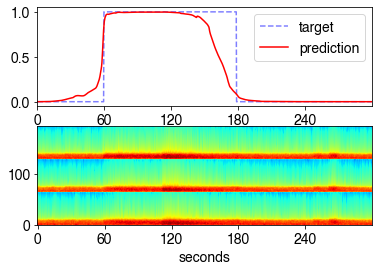

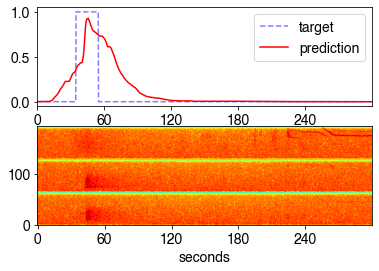

In [154]:
plt.close()
for i in range(10):
    plot_predictions(X_test_spec_three,Y_test_spec_three,test_preds)

In [14]:
# Implementing the model in the time domain

model_wav = model(input_shape=(30000,3))
model_wav.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 30000, 3)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30000, 128)        6272      
_________________________________________________________________
batch_normalization_4 (Batch (None, 30000, 128)        512       
_________________________________________________________________
activation_4 (Activation)    (None, 30000, 128)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30000, 128)        0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 30000, 256)        263168    
_________________________________________________________________
batch_normalization_5 (Batch (None, 30000, 256)        1024

In [7]:
X_train,Y_train = load_multiple(500)

X_train = np.swapaxes(X_train,1,2)
Y_train = np.swapaxes(Y_train,1,2)
Y_train = Y_train[:,:,0]
Y_train = np.expand_dims(Y_train,axis=2)

print(X_train.shape,Y_train.shape)

(500, 30000, 3) (500, 30000, 1)


/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [81]:
optim = Adam(lr=0.005,beta_1=0.9,beta_2=0.999,decay=0.00001)
model_wav.compile(loss='binary_crossentropy', optimizer=optim, metrics=['binary_crossentropy'])

In [95]:
history_wav = model_wav.fit(X_train,Y_train,epochs=10,batch_size=20)

Epoch 1/10
500/500 [==============================] - 1857s 4s/step - loss: 0.3180 - binary_crossentropy: 0.3180
Epoch 2/10
500/500 [==============================] - 1825s 4s/step - loss: 0.3059 - binary_crossentropy: 0.3059
Epoch 3/10
500/500 [==============================] - 1838s 4s/step - loss: 0.2845 - binary_crossentropy: 0.2845
Epoch 4/10
500/500 [==============================] - 1827s 4s/step - loss: 0.2721 - binary_crossentropy: 0.2721
Epoch 5/10
500/500 [==============================] - 1838s 4s/step - loss: 0.2622 - binary_crossentropy: 0.2622
Epoch 6/10
500/500 [==============================] - 1828s 4s/step - loss: 0.2673 - binary_crossentropy: 0.2673
Epoch 7/10
500/500 [==============================] - 1913s 4s/step - loss: 0.2597 - binary_crossentropy: 0.2597
Epoch 8/10
500/500 [==============================] - 1837s 4s/step - loss: 0.2592 - binary_crossentropy: 0.2592
Epoch 9/10
500/500 [==============================] - 1831s 4s/step - loss: 0.2499 - binary_cros

In [ ]:
model_wav.save('model_wave')

In [96]:
X_preds = model_wav.predict(X_train)

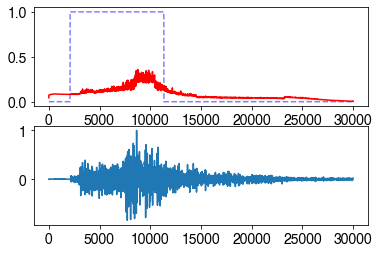

In [120]:
plot_predictions_wav(X_train,Y_train,X_preds)

# Training on the manually cleaned data

In [63]:
X_train,Y_train = load_multiple(1500,folder='batchtest')

X_train = np.swapaxes(X_train,1,2)
Y_train = np.swapaxes(Y_train,1,2)
Y_train = Y_train[:,:,0]
Y_train = np.expand_dims(Y_train,axis=2)

print(X_train.shape,Y_train.shape)

(1500, 30000, 3) (1500, 30000, 1)


In [6]:
def model_wav_uni(input_shape):
    
    X_input = Input(shape=input_shape)
    
    # Convoultion layer
    X = Conv1D(filters=128,strides=1,kernel_size=16,padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.2)(X)
    
    # Bi - LSTM
    X = LSTM(units=128,return_sequences=True)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.2)(X)
    
    # Bi - LSTM 
    X = LSTM(units=128,return_sequences=True)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.2)(X)

    
    X = TimeDistributed(Dense(1,activation='sigmoid'))(X)
    
    
    model=Model(inputs=X_input,outputs=X)
    
    return model

In [9]:

model_wav = model_wav_uni(input_shape=(30000,3))
model_wav.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 30000, 3)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30000, 128)        6272      
_________________________________________________________________
batch_normalization_4 (Batch (None, 30000, 128)        512       
_________________________________________________________________
activation_4 (Activation)    (None, 30000, 128)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30000, 128)        0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30000, 128)        131584    
_________________________________________________________________
batch_normalization_5 (Batch (None, 30000, 128)        512 

In [10]:
optim = Adam(lr=0.005,beta_1=0.9,beta_2=0.999,decay=0.00001)
model_wav.compile(loss='binary_crossentropy', optimizer=optim, metrics=['binary_crossentropy'])

In [40]:
history_wav = model_wav.fit(X_train,Y_train,epochs=20,batch_size=20)

Epoch 1/20
1500/1500 [==============================] - 2944s 2s/step - loss: 0.2095 - binary_crossentropy: 0.2095
Epoch 2/20
1500/1500 [==============================] - 2803s 2s/step - loss: 0.2018 - binary_crossentropy: 0.2018
Epoch 3/20
1500/1500 [==============================] - 2974s 2s/step - loss: 0.1858 - binary_crossentropy: 0.1858
Epoch 4/20
1500/1500 [==============================] - 2755s 2s/step - loss: 0.1776 - binary_crossentropy: 0.1776
Epoch 5/20
1500/1500 [==============================] - 2745s 2s/step - loss: 0.1662 - binary_crossentropy: 0.1662
Epoch 6/20
1500/1500 [==============================] - 2746s 2s/step - loss: 0.1626 - binary_crossentropy: 0.1626
Epoch 7/20
1500/1500 [==============================] - 2765s 2s/step - loss: 0.1597 - binary_crossentropy: 0.1597
Epoch 8/20
1500/1500 [==============================] - 2764s 2s/step - loss: 0.1449 - binary_crossentropy: 0.1449
Epoch 9/20
1500/1500 [==============================] - 2764s 2s/step - loss: 0.

In [41]:
X_preds = model_wav.predict(X_train)

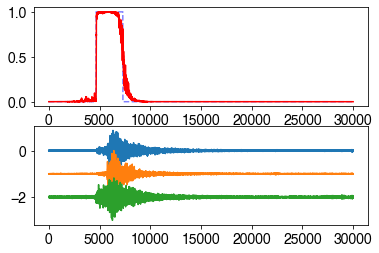

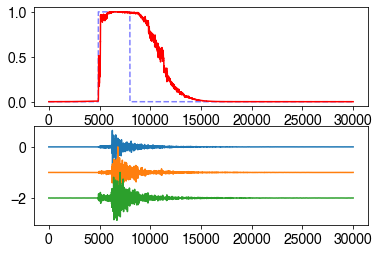

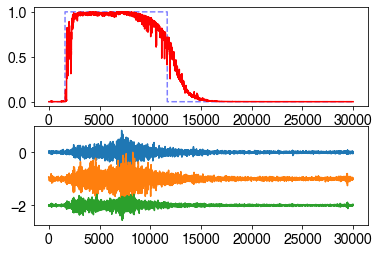

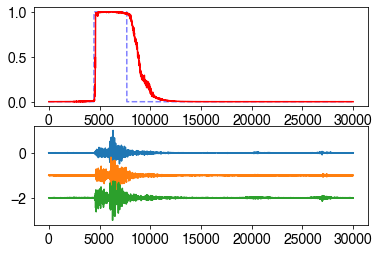

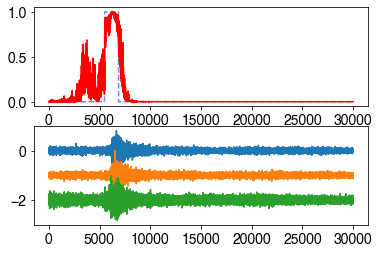

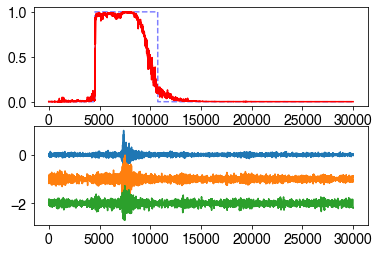

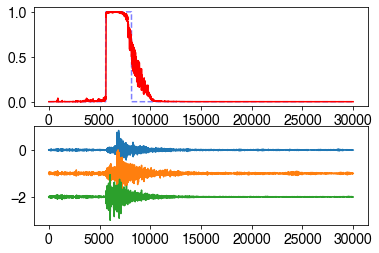

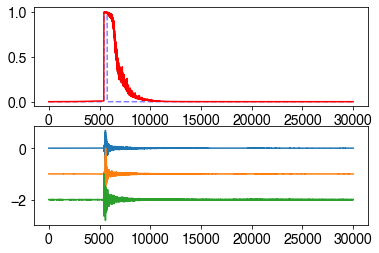

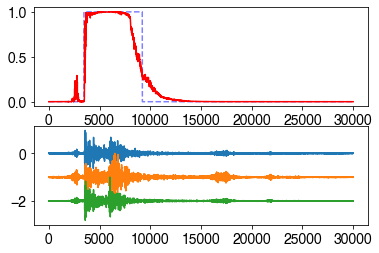

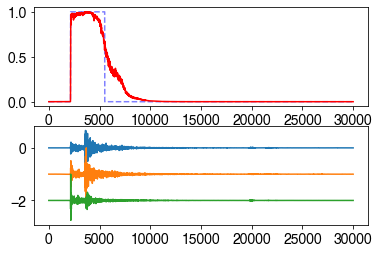

In [46]:
for i in range(10):
    plot_predictions_wav(X_train,Y_train,X_preds)

In [47]:
model_wav.save('model_wav')

In [51]:
X_mul,Y_mul = load_multiple(140,folder='multiplepkl')

X_mul = np.swapaxes(X_mul,1,2)
Y_mul = np.swapaxes(Y_mul,1,2)
Y_mul = Y_mul[:,:,0]
Y_mul = np.expand_dims(Y_mul,axis=2)

print(X_mul.shape,Y_mul.shape)

(140, 30000, 3) (140, 30000, 1)


In [52]:
X_mul_preds = model_wav.predict(X_mul)

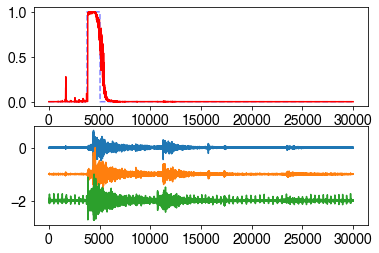

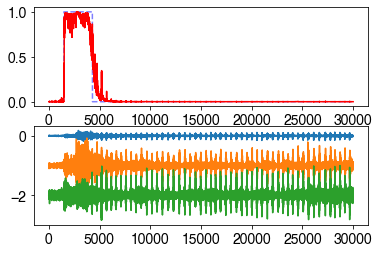

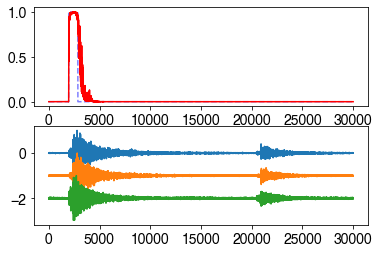

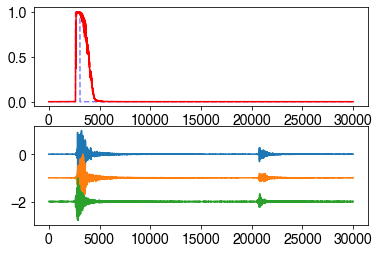

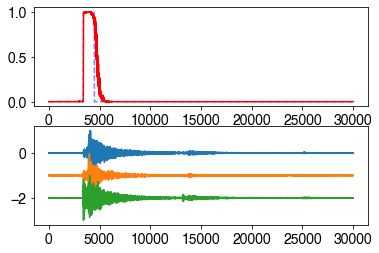

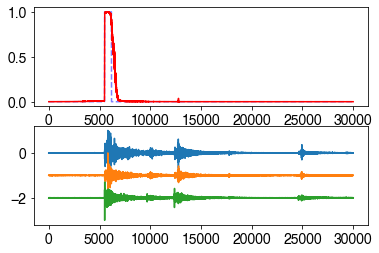

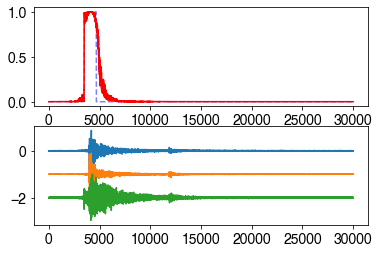

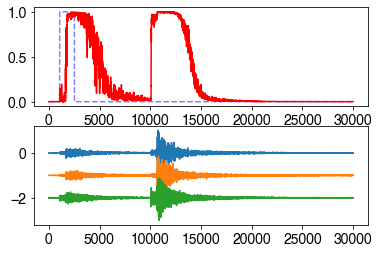

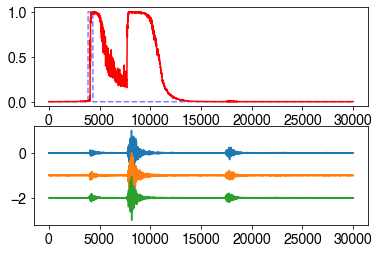

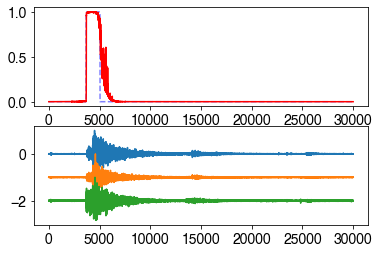

In [56]:
for i in range(10):
    plot_predictions_wav(X_mul,Y_mul,X_mul_preds)

In [58]:
model_wav.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 30000, 3)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30000, 128)        6272      
_________________________________________________________________
batch_normalization_4 (Batch (None, 30000, 128)        512       
_________________________________________________________________
activation_4 (Activation)    (None, 30000, 128)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30000, 128)        0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30000, 128)        131584    
_________________________________________________________________
batch_normalization_5 (Batch (None, 30000, 128)        512 

In [61]:
# using dilated convolution
def model_dilated(input_shape):
    
    X_input = Input(shape=input_shape)
    
    # Convoultion layer
    X = Conv1D(filters=128,strides=1,kernel_size=16,padding='same',dilation_rate=2)(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.2)(X)
    
    # Bi - LSTM
    X = Bidirectional(LSTM(units=128,return_sequences=True))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.2)(X)
    
    # Bi - LSTM 
    X = Bidirectional(LSTM(units=128,return_sequences=True))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.2)(X)

    
    X = TimeDistributed(Dense(1,activation='sigmoid'))(X)
    
    
    model=Model(inputs=X_input,outputs=X)
    
    return model

In [ ]:
model_wav_dilated = model_dilated(input_shape=(30000,3))
optim = Adam(lr=0.005,beta_1=0.9,beta_2=0.999,decay=0.00001)
model_wav_dilated.compile(loss='binary_crossentropy', optimizer=optim, metrics=['binary_crossentropy'])
history_wav = model_wav_dilated.fit(X_train,Y_train,epochs=5,batch_size=20)

Epoch 1/5
1500/1500 [==============================] - 6483s 4s/step - loss: 0.2428 - binary_crossentropy: 0.2428
Epoch 2/5
 960/1500 [==================>...........] - ETA: 35:34 - loss: 0.1847 - binary_crossentropy: 0.1847